# A Notebook to Train a Song Popularity Prediction

## Import Dependencies

In [1]:
import os
from numpy import array
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

from numpy import mean

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

## Load the Data

In [2]:
df = pd.read_csv("Data/train.csv")
test_data = pd.read_csv("Data/test.csv")

In [3]:
Common_Title = ['Mr','Mrs','Master']
name_last = df['Name'].str.split(' ', n=1, expand=True)[1]
title = name_last.str.split(' ', n=1, expand=True)[0]
df['Title'] = title
df['Title'].replace(['Lady','Mlle','Ms','Mme','Miss'],'Mrs',inplace=True)
df['Title'].replace(['Sir', 'Rev'], 'Mr', inplace=True)
df['Title'][~df.Title.isin(Common_Title)] = 'Others'

C:\Users\adnan\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [4]:
Common_Title = ['Mr','Mrs','Master']
name_last = test_data['Name'].str.split(' ', n=1, expand=True)[1]
title = name_last.str.split(' ', n=1, expand=True)[0]
test_data['Title'] = title
test_data['Title'].replace(['Lady','Mlle','Ms','Mme','Miss'],'Mrs',inplace=True)
test_data['Title'].replace(['Sir', 'Rev'], 'Mr', inplace=True)
test_data['Title'][~test_data.Title.isin(Common_Title)] = 'Others'

C:\Users\adnan\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [5]:
name_last = test_data['Name'].str.split(' ', n=1, expand=True)[1]
title = name_last.str.split(' ', n=1, expand=True)[0]
test_data['Title'] = title

In [6]:
le = LabelEncoder()
df['Title'] = le.fit_transform(df['Title'])
test_data['Title'] = le.fit_transform(test_data['Title'])

In [7]:
df["Age"] = df["Age"].fillna(df["Age"]).median()
test_data["Age"] = test_data["Age"].fillna(test_data["Age"]).median()

In [8]:
df['Sex'] = np.where((df.Sex == "male"), 1, 0)
test_data['Sex'] = np.where((test_data.Sex == "male"), 1, 0)

In [9]:
df['Embarked'].fillna('S',inplace=True)
test_data['Embarked'].fillna('S',inplace=True)
df['Embarked'] = np.where((df.Embarked == "S"), 0, np.where((df.Embarked == "C"), 1, 2))
test_data['Embarked'] = np.where((test_data.Embarked == "S"), 0, np.where((test_data.Embarked == "C"), 1, 2))

In [10]:
df['Fare'].fillna(7.854, inplace=True)
test_data['Fare'].fillna(7.854, inplace=True)

In [11]:
print(df.Fare.sort_values(ascending=False).head(5))
df.loc[df.Fare>512, 'Fare'] = 263

258    512.3292
737    512.3292
679    512.3292
88     263.0000
27     263.0000
Name: Fare, dtype: float64


In [12]:
df = df.fillna(0)
test_data = test_data.fillna(0)

In [13]:
print("Shape of Train Data: ", df.shape)
df.head()

Shape of Train Data:  (891, 13)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,28.0,1,0,A/5 21171,7.2500,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,28.0,1,0,PC 17599,71.2833,C85,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,28.0,0,0,STON/O2. 3101282,7.9250,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,28.0,1,0,113803,53.1000,C123,0,0
4,5,0,3,"Allen, Mr. William Henry",1,28.0,0,0,373450,8.0500,0,0,0


In [14]:
print("Shape of Train Data: ", test_data.shape)
test_data.head()

Shape of Train Data:  (418, 12)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",1,27.0,0,0,330911,7.8292,0,2,9
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,27.0,1,0,363272,7.0000,0,0,10
2,894,2,"Myles, Mr. Thomas Francis",1,27.0,0,0,240276,9.6875,0,2,9
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,0,0,9
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,27.0,1,1,3101298,12.2875,0,0,10


## Perform Data Pre-Processing

In [15]:
df_quantitative = df
cols_to_drop = ["PassengerId", "Name", "Ticket", "Cabin"]
df_quantitative = df.drop(columns=cols_to_drop)
print(f"Working dataset shape: {df_quantitative.shape}")

Working dataset shape: (891, 9)


In [16]:
#normalize the dataset
df_quan_2016_nm=df_quantitative.copy()
df_quan_2016_nm

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,1,28.0,1,0,7.2500,0,0
1,1,1,0,28.0,1,0,71.2833,1,0
2,1,3,0,28.0,0,0,7.9250,0,0
3,1,1,0,28.0,1,0,53.1000,0,0
4,0,3,1,28.0,0,0,8.0500,0,0
...,...,...,...,...,...,...,...,...,...
886,0,2,1,28.0,0,0,13.0000,0,0
887,1,1,0,28.0,0,0,30.0000,0,0
888,0,3,0,28.0,1,2,23.4500,0,0
889,1,1,1,28.0,0,0,30.0000,1,0


## Feature Engineering

In [17]:
df_quan_2016_nm.corr()["Survived"]

Survived    1.000000
Pclass     -0.338481
Sex        -0.543351
Age              NaN
SibSp      -0.035322
Parch       0.081629
Fare        0.270984
Embarked    0.106811
Title            NaN
Name: Survived, dtype: float64

## Train-Test Split

In [18]:
#creates a mask, randomly selects 80% of the songs

df_train_full = df_quan_2016_nm.sample(frac=0.8,random_state=1) #random state is a seed value
df_test = df_quan_2016_nm.drop(df_train_full.index)

df_validation = df_train_full.sample(frac=0.2,random_state=2) # create a validation set from training set
df_train = df_train_full.drop(df_validation.index)

## Build the Model

In [19]:
# seperate the data, the Y is what we want to predict

predict = "Survived"
X_train = df_train.drop(columns=[predict])
X_validation = df_validation.drop(columns=[predict])
X_test = df_test.drop(columns=[predict])

Y_train = df_train[[predict]].values.ravel()
Y_validation = df_validation[[predict]].values.ravel()
Y_test = df_test[[predict]].values.ravel()

## Train the Model

In [20]:
model = RandomForestClassifier(n_estimators=100 , criterion='entropy')
model.fit(X_train, Y_train)
print(model.score(X_validation, Y_validation))

Y_pred_temp = model.predict_proba(X_test)[:, 1]
Y_pred = []
for i in Y_pred_temp:
    if i < 0.70:
        Y_pred.append(0)
    else:
        Y_pred.append(1)
print('Classification Report')
print(classification_report(Y_test, Y_pred))

0.7762237762237763
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       117
           1       0.81      0.69      0.74        61

    accuracy                           0.84       178
   macro avg       0.83      0.80      0.81       178
weighted avg       0.83      0.84      0.83       178



(array([52., 37., 10.,  7.,  4.,  9.,  7.,  2., 12., 38.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

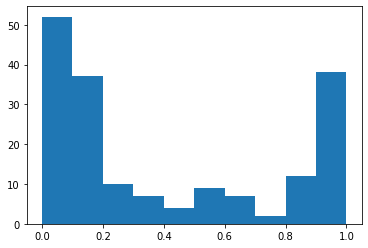

In [21]:
plt.hist(Y_pred_temp)

## Test The Model

In [22]:
results_df = pd.DataFrame(columns = ["PassengerId", "Survived"])
for index, row in test_data.iterrows():
    row = row.to_frame()
    row = row.T
    id = row["PassengerId"]
    row = row.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis = 1)
    prediction = model.predict_proba(row)[:, 1]
    if prediction < 0.70:
        prediction = 0
    else:
        prediction = 1
    to_append = [list(id)[0], prediction]
    a_series = pd.Series(to_append, index = results_df.columns)
    results_df = results_df.append(a_series, ignore_index=True)

In [23]:
print("Shape of Train Data: ", results_df.shape)
results_df.head()

Shape of Train Data:  (418, 2)


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [24]:
results_df = results_df.astype(int)

In [25]:
results_df.dtypes

PassengerId    int32
Survived       int32
dtype: object

In [26]:
results_df["Survived"].value_counts()

0    297
1    121
Name: Survived, dtype: int64

In [27]:
results_df.to_csv("Results.csv", index = False, encoding='utf-8')